In [ ]:
#---------------------------------------------------------------------------------
#Project     : Erasmus + NEON
# Authors    : Graciela Corral Briones
# Affiliation: UNC
# E-mail     : graciela.corral@unc.edu.ar
#---------------------------------------------------------------------------------

In [5]:
#LIBRERIAS UTILIZADAS
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import spectrogram

#Referencias Principales

*   Lorenzo Vangelista, Frequency Shift Chirp Modulation: The LoRa Modulation
*   Video resumen del paper de Lorenzo: How LoRa Modulation really works
 *   https://www.youtube.com/watch?v=jHWepP1ZWTk&t=856s

*   LoRa Modulation
 *   https://en.wikipedia.org/wiki/LoRa

# Modulación lora

LoRa es una modulación de espectro expandido que utiliza la técnica chirp que consiste en modular el mensaje por medio de una señal que varía la frecuencia de manera continua y lineal.




## Parámetros de la modulación

**SF (Spreading factor)**

El spreading factor define dos valores fundamentales:

- El número de chips contenidos por símbolo, dado por $2^{SF}$
- El número de bits de cada simbolo, dado por SF.

Para este tipo de modulacion su valor esta entre [7-12]

Por ejemplo:

-  Para un SF de 7, se tiene 128 chips por simbolo. Cada símbolo transmite 7 bits

**B (BandWidth)**

Ancho de banda definido para la transmisión

**Ts (Symbol time)**

Tiempo que tarda en enviarse un símbolo, dado por $\frac{2^{SF}}{Bw}$


**T (Tiempo de muestra)**

Delta de tiempo en el cual se toma una muestra $T$ = $\frac{1}{Bw}$

**s (Symbol)**

Símbolo a transmitir, toma valores entre $\{0,...,2^{SF}-1\}$

La forma de onda transmitida de duración $T_s$ para cada $s(nT_s)$ es la siguiente:
$$c(nT_s+kT) = \frac{1}{\sqrt{2^{SF}}} e^{j2\pi \left[ (s(nT_s)+k)_{mod}2^{SF}\right]kT\frac{B}{2^{SF}}}$$

$\text{para } k=0,1,...,2^{SF}-1$


# Forma de onda en frecuencia

A continuacion se muestra la forma de onda en el dominio de frecuencia de la señal modulada en chirp de un símbolo.

In [6]:
#----------------------------- FUNCIONES ------------------------------------------------------------
def generate_chirp(simbolo, sf, Bw, time_interval, samples):

  M = 2**sf
  Ts = M/np.abs(Bw)      
  wf_f = []

  for i in range(samples):
    wf_f.append((simbolo*np.abs(Bw)/M + Bw/Ts*time_interval[i]) % np.abs(Bw)) 

  return wf_f  

def generate_symbols(sf, n_data, Bw, samples, ):
        
  data = []
  chirps = np.array([])
  Ts =  2**sf/Bw #Tiempo de simbolo   
  t_c = np.linspace(0, Ts, samples)

  for i in range(n_data):
    data.append(np.random.randint(0, 2**sf))
    chirps = np.append(chirps, generate_chirp(data[i], sf, Bw, t_c, samples))

  return np.array(data), chirps

def plot_waveform(ax, t, wf, axis_x_label, axis_y_label, title, Ts, len_packet_tx):
            
  ax.set_facecolor('black')
  ax.set_title(title, fontdict={'color':'white','weight':'bold','size' : 20}, pad = 20)
  ax.set_xlabel(axis_x_label, fontdict={'color':'white','weight':'bold','size' : 20}, labelpad = 10)
  ax.set_ylabel(axis_y_label, fontdict={'color':'white','weight':'bold','size' : 20}, labelpad = 5)
  ax.tick_params(axis='both', which='major', labelsize=10, colors='white')
  ax.set_xticks(np.arange(0, len_packet_tx, Ts))
  ax.xaxis.set_major_formatter(plt.FormatStrFormatter('%.3f'))
  ax.plot(t, wf, lw=2)   
  ax.grid()    


Simbolo transmitido 50


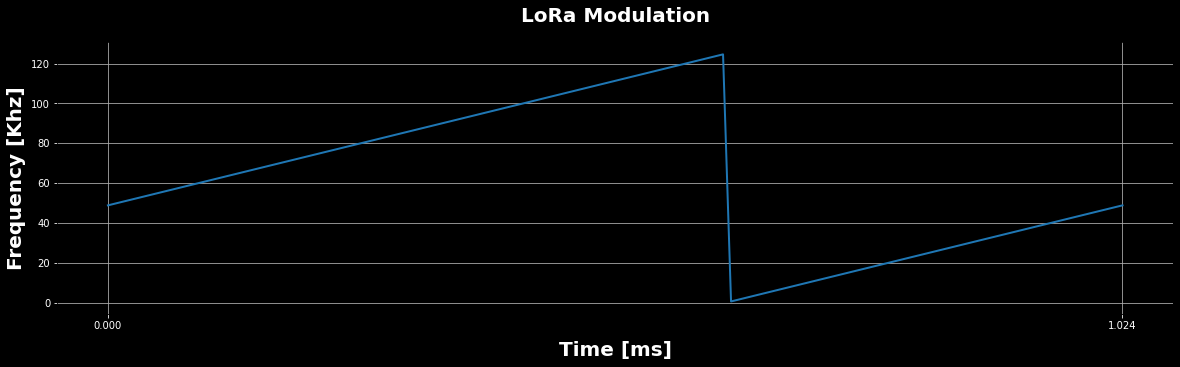

In [7]:
#------------------------------ MAIN --------------------------------------------------------------------------
sf = 7 #Spreading factor
Bw = 125 #Khz
Ts = 2**sf/Bw #Tiempo de simbolo
n_data = 1 # numero de datos a transmitir
spc = 1  # samples per 1/B 
sps = int(2**sf * spc) #samples = int(2**sf*1/delta) # samples per symbol 
variance= 0.13

#symbs, data_tx_f  = generate_symbols(sf, n_data, Bw, sps) # symbs son los datos generados aleatoriamente, data_tx son los crirp en frecuencia
t_c = np.linspace(0, Ts, sps)
symb = 50
data_tx_f = generate_chirp(symb, sf, Bw, t_c, sps)

print("Simbolo transmitido", symb)
# Grafico Frecuencia vs tiempo
fig1, ax1 = plt.subplots(1, figsize = (20, 5))    
fig1.patch.set_facecolor('black')

t = np.linspace(0, Ts, sps)

# Grafico Frecuencia vs tiempo
plot_waveform(ax1, t, data_tx_f, "Time [ms]", "Frequency [Khz]", "LoRa Modulation", Ts, sps)

Como se puede observar en las imagenes anteriores, el chirp se incrementa linealmente desde una frecuencia inicial (simbolo a transmitir) a una frecuencia maxima ${BW}$-$\frac{BW}{2^{SF}}$ . Una vez que llegue a la frecuencia maxima decae a la frecuencia 0 y se vuelve incrementar linealmente hasta el simbolo inicial.

# Forma de onda en tiempo

A continuacion se muestra la forma de onda de la señal modulada en tiempo para transmitir solo un simbolo.

$$c(nT_s+\frac{kT}{spc}) = \frac{1}{\sqrt{2^{SF}}} e^{j2\pi \left[ (s(nT_s)+k)_{mod}2^{SF}\right]\frac{k}{spc*2^{SF}}}$$

El siguiente codigo permite generar la waveform en tiempo con ruido gaussiano y sin ruido para ver las diferencias.

Parametros:
  - symb: Simbolo a transmitir (representa la frecuencia inicial de la waveform)
  - sf: spreading factor
  - B: ancho de banda del canal.
  - spc: cantidad de muestras en el tiempo 1/B
  - sps: cantidad de muestras por símbolo

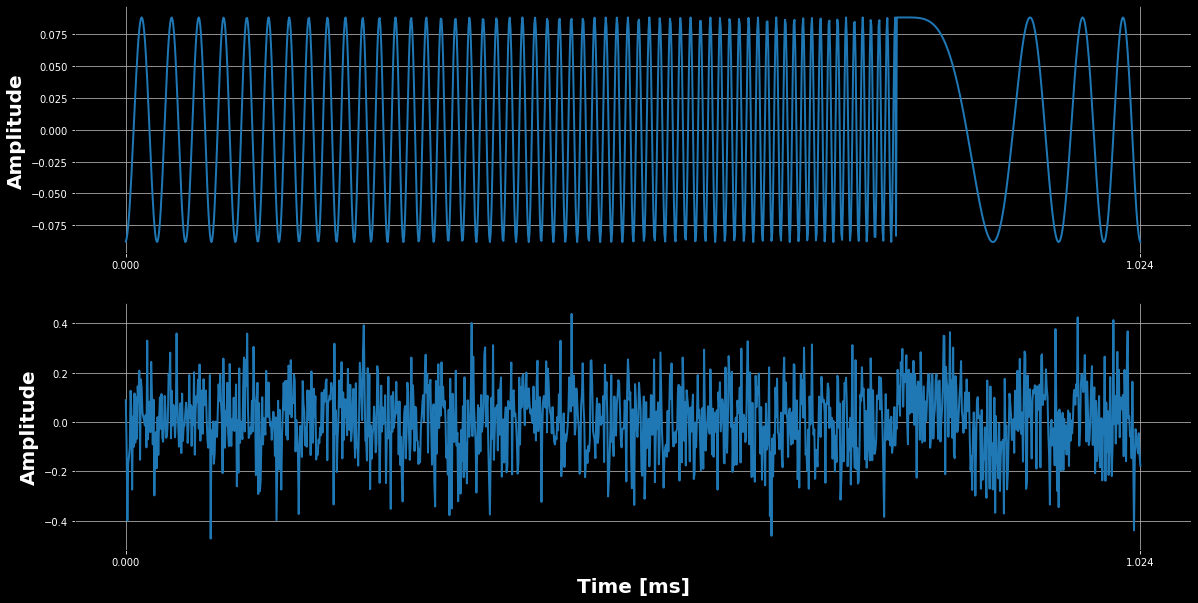

In [8]:
#---------------------------------------------FUNCIONES-----------------------------------------------------
def waveform_chirp_time(symb, sf, Bw, spc, samples):
       
  Ts =2**sf
  T = 1/Bw
  delta = 1/spc    
  wf = np.array([])       
        
  fMax = (2**sf-1)*Bw/(2**sf)
  k = symb
  
  for n in range(samples):
    f = k*Bw/(2**sf)
    t = k*T
    if (f > fMax):
      k = k-Ts
      f = k*Bw/(2**sf)

    sample = (1/(np.sqrt(2**sf)))*np.exp(1j*2*np.pi*f*t*1/2)
    wf = np.append(wf, sample)

    k += delta

  return  wf

def add_noise_gaussiano(tx_signal, mean, variance):
         
  wn = generate_awgn(mean, variance, len(tx_signal))        
  rx_signal = (tx_signal + wn)

  return rx_signal

def generate_awgn(mean, variance, samples):     
  return np.random.normal(mean, variance, samples) #creando muestra de ruido

def plot_waveform(ax, t, wf, axis_x_label, axis_y_label, title, Ts, len_packet_tx):
            
  ax.set_facecolor('black')
  ax.set_title(title, fontdict={'color':'white','weight':'bold','size' : 20}, pad = 20)
  ax.set_xlabel(axis_x_label, fontdict={'color':'white','weight':'bold','size' : 20}, labelpad = 10)
  ax.set_ylabel(axis_y_label, fontdict={'color':'white','weight':'bold','size' : 20}, labelpad = 5)
  ax.tick_params(axis='both', which='major', labelsize=10, colors='white')
  ax.set_xticks(np.arange(0, len_packet_tx, Ts))
  ax.xaxis.set_major_formatter(plt.FormatStrFormatter('%.3f'))
  ax.plot(t, wf, lw=2)   
  ax.grid()

#---------------------------------------------MAIN----------------------------------------------------------
sf = 7 #Spreading factor
Bw = 125 #Khz
Ts = 2**sf/Bw #Tiempo de simbolo
spc = 10
sps = int(2**sf * spc)
variance = 0.13

packet_tx_t = np.array([]) #waveform en tiempo

symb = 30 # simbolo a transmitir

packet_tx_t = np.append(packet_tx_t, waveform_chirp_time(symb, sf, Bw, spc, sps)) # chirp en tiempo

# Grafico Amplitud vs tiempo sin ruido gaussiano

fig1, [ax1, ax2] = plt.subplots(2, figsize = (20, 10))    
fig1.patch.set_facecolor('black')

t = np.linspace(0, Ts, sps)

plot_waveform(ax1, t, np.real(packet_tx_t), "", "Amplitude", "", Ts, sps)

# Grafico Amplitud vs tiempo sin ruido gaussiano

rx_signal = add_noise_gaussiano(packet_tx_t, 0, variance) # waveform en tiempo con ruido gaussiano
plot_waveform(ax2, t, np.real(rx_signal), "Time [ms]", "Amplitude", "", Ts, sps)

[![CC BY 4.0][cc-by-shield]][cc-by]

This work is licensed under a
[Creative Commons Attribution 4.0 International License][cc-by].

[![CC BY 4.0][cc-by-image]][cc-by]

[cc-by]: http://creativecommons.org/licenses/by/4.0/
[cc-by-image]: https://i.creativecommons.org/l/by/4.0/88x31.png
[cc-by-shield]: https://img.shields.io/badge/License-CC%20BY%204.0-lightgrey.svg

![logo_neon_erasmus](https://raw.githubusercontent.com/neon-iot/communication_labs/main/detection_theory/notebooks/images/BannerSupportErasmus_.png)
